In [1]:
import numpy as np
!pip install tensorboardcolab
import torch
from torchvision import datasets, transforms
import helper
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import summary
import datetime
import pandas as pd
from collections import OrderedDict
from os import mkdir
from os.path import isdir
from glob import glob
from pathlib import Path
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from google.colab import drive
import seaborn as sns
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Read input data

In [0]:
ROOT_PATH = Path('/content/drive/My Drive/DL/Project/experiments/ate/')
DATA_PATH = ROOT_PATH/'data/' 
SEED = 42

x = pd.read_csv(DATA_PATH/'X_one_hot.csv')
gestat_simulated = pd.read_csv(DATA_PATH/'gestat10.csv',header = None)[0]
heavier_tween_first = pd.read_csv(DATA_PATH/'heavier_tween_born_first.csv',header = None)[0]
y = pd.read_csv(DATA_PATH/'Y.csv')

## Simulate observational study

In [0]:
def get_simulated_data(x,y,gestat10, w_0, w_h,heavier_tween_first):
    p_heavier =  x@w_0 + w_h*(gestat10.astype('float')*0.1-0.1)
    p_heavier_norm = (p_heavier - p_heavier.min()) / (p_heavier.max() - p_heavier.min())
    t_s = (np.random.random(x.shape[0]) < p_heavier_norm)*1 # t = 1 means heavier
    y_s = []
    birth_order = []
    for i,tween in enumerate(t_s):
        y_s.append(y.values[i,tween])
        if tween == 1: # if the hevier tween 
            is_hevier = heavier_tween_first[i]
        else:
            is_hevier = not heavier_tween_first[i]
        birth_order.append(is_hevier*1)
    temp_x = x.copy()
    temp_x["birth_order"] =  birth_order
    return temp_x,np.array(y_s),t_s

## Propensity score model

In [0]:
class PS_NN(nn.Module):
  def __init__(self):
    super().__init__() 
    self.fc1 = nn.Linear(163, 10) 
    # self.fc2 = nn.Linear(20, 20) 
    self.fc3 = nn.Linear(10, 2) 
    self.fc4 = nn.Linear(163, 2) 
    self.softmax = nn.LogSoftmax(dim=1)
    self.regulizer = nn.Dropout(0.05)

  def forward(self, x):
    x = F.relu(self.fc1(x)) 
    x = self.regulizer(x) 
    # x = F.relu(self.fc2(x)) 
    # x = self.regulizer(x) 
    x = F.relu(self.fc3(x)) 
    x= self.softmax(x)

    # x = self.softmax(self.fc4(x))
    return x

## Trainer

In [0]:
from sklearn.model_selection import train_test_split

def get_batch(x,y,batch_size,device):
  batches = np.arange(0,x.shape[0],batch_size)
  for i in range(len(batches)-1):
    inputs, targets = torch.from_numpy(x[batches[i]:batches[i+1],:]), torch.from_numpy(y[batches[i]:batches[i+1]])
    inputs = inputs.to(device).float()
    targets = targets.to(device, dtype=torch.int64)
    yield inputs, targets

class Trainer:
  def __init__(self,model, config):
    self.model = model
    self.model_name = config.model_name
    self.lr = config.lr
    self.epochs = config.epochs
    self.save_model = config.save_model
    self.upload_model = config.upload_model
    self.model_weights_path = config.model_weights_path
    self.batch_size =  config.batch_size
    self.dropout_std_n_times = config.dropout_std_n_times
    self.momentum = config.momentum
    self.optimizer = optim.SGD(self.model.parameters(), lr = self.lr, weight_decay = config.weight_decay, momentum=self.momentum)
    self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=config.step_size, gamma=config.gamma)
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    class_weights = torch.FloatTensor([0.657,0.342]).to(self.device)
    self.criterion = nn.NLLLoss(weight=class_weights,reduction='none')
    self.results = {}
    self.sgd_spv_matrix = {}
    self.warmup_epochs = config.warmup_epochs
    self.eps = config.eps
    if torch.cuda.is_available():
      self.model.to(self.device)

  def get_results(self):
    return pd.DataFrame.from_dict(self.results)

  def record(self,epoch,**kwargs):
    epoch = "{:02d}".format(epoch)
    temp = f"| epoch   # {epoch} :"
    for key, value in kwargs.items():
      key = f"{self.model_name}_{key}"
      if not self.results.get(key):
        self.results[key] =[]
      self.results[key].append(value)
      val = '{:.4f}'.format(np.round(value,4))
      temp += f"{key} : {val}      |       "
    print(temp)


  def fit(self,x,y, exp_name): 
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.12)
    train_accu, test_accu, output_plot = [],[],[]
    for epoch in range(1,self.epochs+1):
      weights_path = Path(f"{self.model_weights_path}/{config.model_name}_{epoch}.pth")
      train_metric, train_loss = self.run_epoch(x_train, y_train, epoch)
      validation_metric, validation_loss = self.val(x_val, y_val,epoch)
      self.record(epoch,
                  train_acc = train_metric,
                  train_loss = train_loss,
                  test_acc = validation_metric,
                  validation_loss = validation_loss)


  def run_epoch(self, x,y,epoch):
    self.model.train()
    train_loss , train_metric = 0, 0
    for batch , (inputs, labels) in enumerate(get_batch(x,y,self.batch_size,self.device)):
      loss = self.get_loss(inputs, labels, batch, epoch)  #self.weighted_loss(images, labels, i, epoch)
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()
      self.scheduler.step()
      train_loss += self.get_loss(inputs, labels, i, epoch, False).item()
      train_metric += self.calc_accuracy(inputs,labels,return_labels=False)
    accuracy = train_metric/(batch+1)
    return accuracy,train_loss


  def val(self, x,y, epoch):
    self.model.eval()
    val_loss , val_metric = 0, 0
    with torch.no_grad():
      for batch , (inputs, labels) in enumerate(get_batch(x,y,self.batch_size,self.device)):
        acc = self.calc_accuracy(inputs,labels)
        val_metric += acc 
        val_loss += self.get_loss(inputs, labels, batch, epoch, False).item()
    acuuracy = val_metric/(batch+1)
    return acuuracy,val_loss

  def get_loss(self,x, y, batch, epoch,weighted=True):
    loss = self.criterion(self.model(x), y)
    weights = torch.ones(x.size()[0], device= self.device)
    if weighted and (epoch >= self.warmup_epochs + 1) and (self.model_name != 'baseline'):
        epoch_of_weighted_training = epoch - (self.warmup_epochs + 1) 
        weights = self.weighted_loss(x, y,batch, epoch_of_weighted_training) 
    return (loss*weights).mean()
    

  def weighted_loss(self, x, labels, batch, epoch_weighted, is_test=False):
    total_weighted_epochs = self.epochs - self.warmup_epochs
    batch_size = x.size()[0] 
    #row_indexes = [i for i in range(self.batch_size)]
    with torch.no_grad():
      weights = torch.ones(batch_size, device= self.device)

      if self.model_name == 'MCdropout' or is_test:  
        all_p =  torch.zeros((batch_size #self.batch_size,
                              ,self.dropout_std_n_times), device= self.device)
        for i in range(self.dropout_std_n_times):
          p = torch.exp(self.model(x))
          p_true_labels = torch.gather(p, 1, labels.view(-1,1))
          #p_true_labels = p[row_indexes,labels]
          all_p[:,i] = p_true_labels.view(-1)
          weights = all_p.std(axis = 1)

      elif self.model_name == 'entropy':
        log_p = self.model(x)
        weights = -torch.mul(log_p, torch.exp(log_p)).sum(axis = 1)

      elif self.model_name == 'SGD-WPV':
        self.sgd_spv_matrix.setdefault(batch, torch.zeros((batch_size #self.batch_size,
                                                          ,total_weighted_epochs), device= self.device))
        # update_matrix
        p = torch.exp(self.model(x))
        p_true_labels = torch.gather(p, 1, labels.view(-1,1))
        #p_true_labels = p[row_indexes,labels]
        self.sgd_spv_matrix[batch][:,epoch_weighted] = p_true_labels.view(-1)
        if epoch_weighted not in [0,1]:
          indexes = [i for i in range(epoch_weighted)]
          var = self.sgd_spv_matrix[batch][:,indexes].var(axis = 1)
          var +=  var.pow(2)/(len(indexes) -1)
          weights = var.sqrt()
        # else:
        #   weights = torch.ones(x.size()[0], device= self.device) # no history, or no variance -> equal weights
      weights += self.eps
      return (weights/weights.mean())


  def get_ps(self, x):
    with torch.no_grad():
      x = torch.from_numpy(x).to(self.device).float()
      return torch.exp(self.model(x)).cpu().numpy()[:,1]


  def calc_accuracy(self, images, labels, return_labels=False):
    self.model.eval()
    log_ps = self.model(images)
    ps = torch.exp(log_ps)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    acc = torch.mean(equals.type(torch.FloatTensor))
    if return_labels:
      predicted_lables = top_class.view(-1).cpu().tolist()
      ps_labels = torch.gather(ps, 1, labels.view(-1,1))
      self.model.train()
      return acc, predicted_lables, ps_labels.view(-1).cpu().tolist()
    self.model.train()
    return acc


  def save_checkpoint(self,weights_path,loss):
    if (not weights_path.exists()) and self.save_model: 
      torch.save({'model_state_dict': self.model.state_dict(),
              'optimizer_state_dict': self.optimizer.state_dict(),'loss': loss}, weights_path)
      
  def load_checkpoint(self,weights_path,epoch):
    checkpoint = torch.load(weights_path)
    self.model.load_state_dict(checkpoint['model_state_dict'])
    self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    self.model.to(self.device)
    loss = checkpoint['loss']
    print(f"Uploaded weights succesfuly at epoch number {epoch}")
    return loss


## Utils

In [0]:
import time
def change_seed():
  t = 1000 * time.time() # current time in milliseconds
  np.random.seed(int(t) % 2**32)

def calculate_ate_ate_estimated(res):
  ate_hat = (res['y']*res['t']/res['ps'] -res['y']*(1-res['t'])/(1-res['ps'])).mean()
  ate_true = (res['mort_1']-res['mort_0']).mean()
  return ate_true, ate_hat

def calculate_ates(res,alpha = 0.1):
  ate_true, ate_hat = calculate_ate_ate_estimated(res)
  res = res[res['ps'].between(0+alpha, 1- alpha)]
  ate_true_with_alpha, ate_hat_with_alpha = calculate_ate_ate_estimated(res)
  return [ate_true, ate_hat, ate_true_with_alpha, ate_hat_with_alpha]
  # print(F"true ate is {ate_true} and estimated ate is {ate_hat}")


def get_results_df(propensity_score, t,y_simulated,y_all):
  results = pd.DataFrame()
  results['ps'] = propensity_score
  results['t'] = t
  results['y'] = y_simulated 
  return pd.concat([results,y_all], axis = 1)

class Config:  
  def __init__(self, **kwargs):
    for key, value in kwargs.items():
      setattr(self, key, value)

  def add_attributes(self,**kwargs):
    for key, value in kwargs.items():
      setattr(self, key, value)

## Config

In [0]:
MODEL_WEIGHTS_DIR = 'model_weights'
GRAPHS_FOLDER_NAME = 'graphs'
model_weights_dir = f"{ROOT_PATH}{MODEL_WEIGHTS_DIR}" 
graphs_dir = f"{ROOT_PATH}{GRAPHS_FOLDER_NAME}" 
N_EXP = 3

def get_base_config():
  SAVE_TO_CHECKPOINTS = False
  LOAD_CHECKPOINTS = False 
  return Config(
          lr = 0.00001,
          warmup_epochs = 1,
          epochs = 100,
          step_size=2,
          gamma=0.95,
          eps= 0.0001,
          weight_decay=0.001,
          dropout_std_n_times = 15,
          momentum = 0.9,
          save_model = SAVE_TO_CHECKPOINTS,
          upload_model = LOAD_CHECKPOINTS,
          model_weights_path = model_weights_dir,
          batch_size = 16)
  
ate_columns =  ['ATE_TRUE_ALL_POPULATION', 'ATE_HAT_ALL_POPULATION', 'ATE_TRUE_POPULATION_BETWEEN [a,1-a]', 'ATE_HAT_POPULATION_BETWEEN [a,1-a]']
np.random.seed(SEED)
w_0 = np.random.normal(0,0.1,x.shape[1])
w_h = np.random.normal(3,0.1)
seeds = np.random.choice([i for i in range(100)],N_EXP,replace = False)

## Run experiments

In [8]:
from sklearn.metrics import roc_auc_score
all_pop_ate = y['mort_1'].mean()- y['mort_0'].mean()
config = get_base_config()
all_ate = []
for exp in ['baseline','entropy','MCdropout','SGD-WPV']:
  ate = []
  for i in range(N_EXP):
    torch.manual_seed(seeds[i])
    change_seed()
    X,Y,T = get_simulated_data(x,y,gestat_simulated, w_0, w_h,heavier_tween_first)
    X,T = X.values.astype('float64'),T.values.astype('float64')
    config.add_attributes(model_name = exp)
    trainer = Trainer(PS_NN(), config)
    trainer.fit(X,T, exp)
    ps = trainer.get_ps(X) 
    print(F"auc is {roc_auc_score(T, ps)}")
    results = get_results_df(ps, T,Y,y)
    ate.append(calculate_ates(results))
  ate = pd.DataFrame(ate,columns = ate_columns)
  ate['exp'] = exp
  all_ate.append(ate)

| epoch   # 01 :baseline_train_acc : 0.6600      |       baseline_train_loss : 253.4460      |       baseline_test_acc : 0.6669      |       baseline_validation_loss : 34.5468      |       
| epoch   # 02 :baseline_train_acc : 0.6600      |       baseline_train_loss : 253.4216      |       baseline_test_acc : 0.6669      |       baseline_validation_loss : 34.5711      |       
| epoch   # 03 :baseline_train_acc : 0.6600      |       baseline_train_loss : 253.4776      |       baseline_test_acc : 0.6669      |       baseline_validation_loss : 34.5990      |       
| epoch   # 04 :baseline_train_acc : 0.6600      |       baseline_train_loss : 253.4369      |       baseline_test_acc : 0.6669      |       baseline_validation_loss : 34.5396      |       
| epoch   # 05 :baseline_train_acc : 0.6600      |       baseline_train_loss : 253.4678      |       baseline_test_acc : 0.6669      |       baseline_validation_loss : 34.5397      |       
| epoch   # 06 :baseline_train_acc : 0.6600      |

##################################################
baseline
##################################################


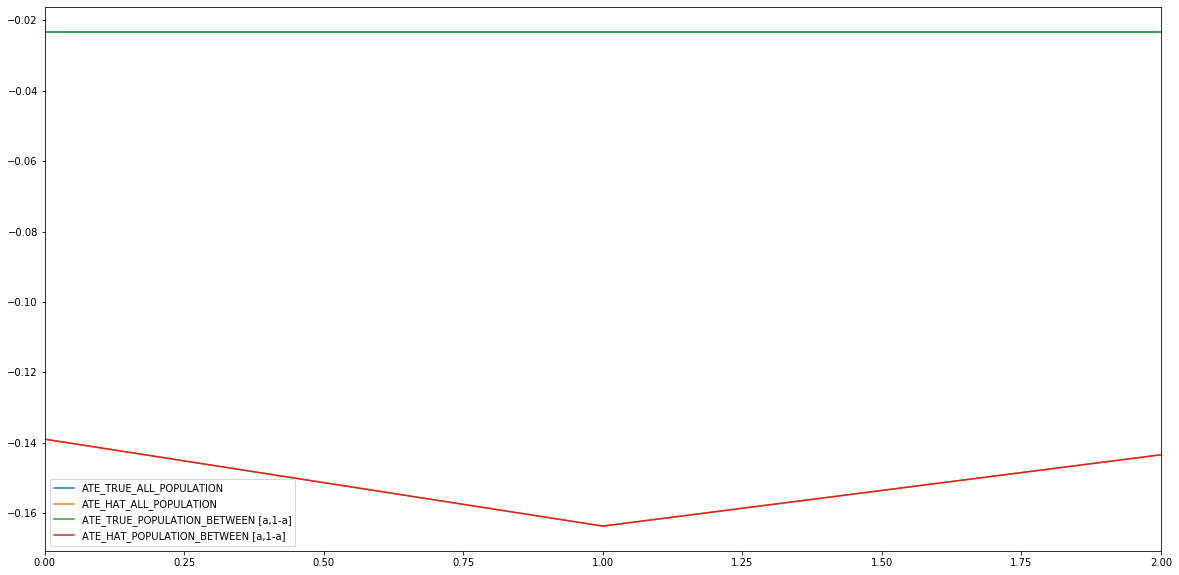

true ate estimator is 0.12535 +- 0.01074
alpha ate estimator is 0.12535 +- 0.01074
##################################################
entropy
##################################################


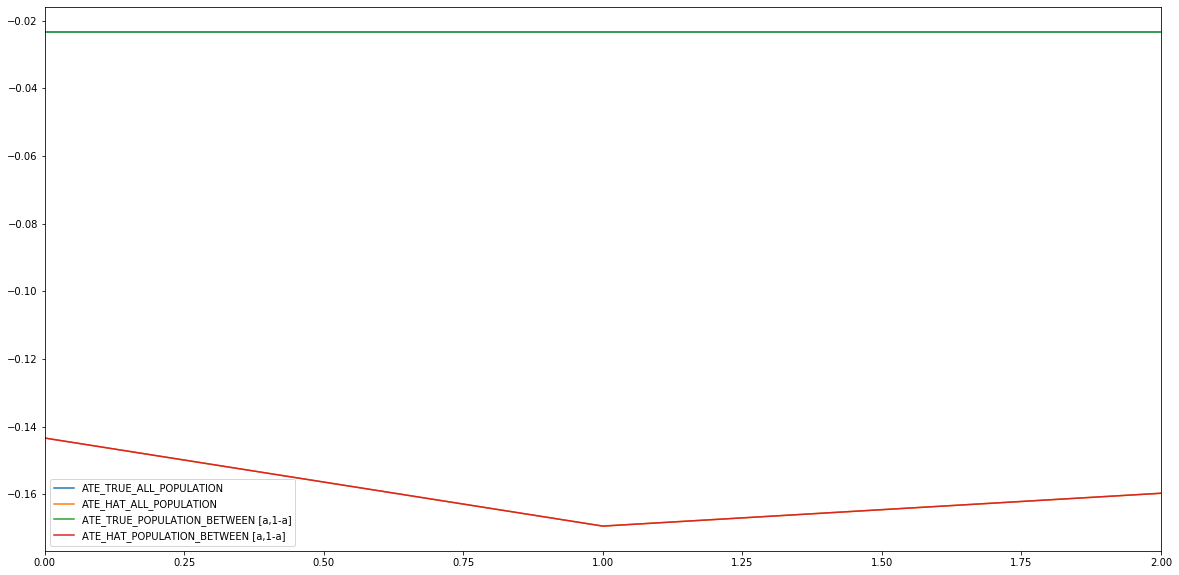

true ate estimator is 0.13414 +- 0.01073
alpha ate estimator is 0.13414 +- 0.01073
##################################################
MCdropout
##################################################


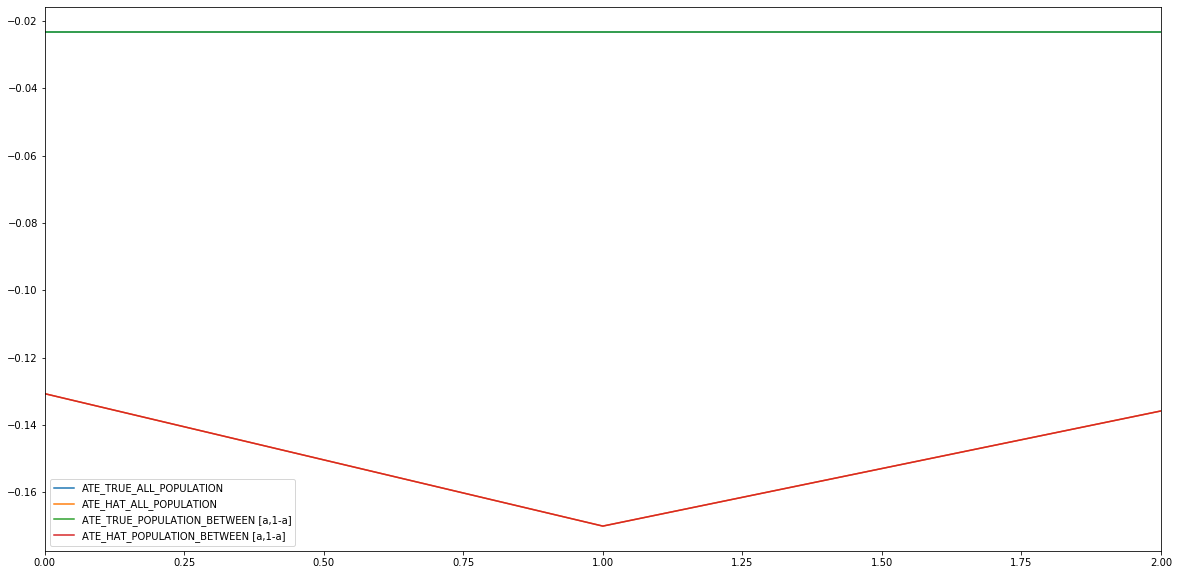

true ate estimator is 0.12217 +- 0.01744
alpha ate estimator is 0.12217 +- 0.01744
##################################################
SGD-WPV
##################################################


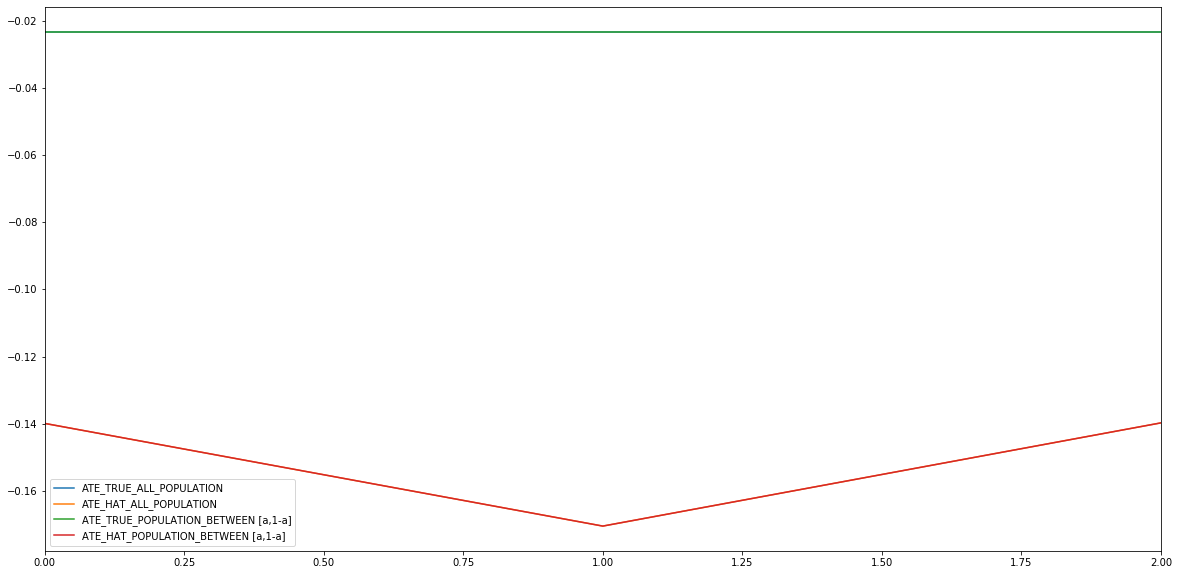

true ate estimator is 0.12669 +- 0.01444
alpha ate estimator is 0.12669 +- 0.01444


In [9]:
def calculate_ates(res,alpha = 0.1):
  ate_true, ate_hat = calculate_ate_ate_estimated(res)
  res = res[res['ps'].between(0+alpha, 1- alpha)]
  ate_true_with_alpha, ate_hat_with_alpha = calculate_ate_ate_estimated(res)
  return [ate_true, ate_hat, ate_true_with_alpha, ate_hat_with_alpha]

all_results = pd.concat(all_ate)
for exp in all_results['exp'].unique(): 
  print("#"*50)
  print(exp)
  print("#"*50)
  exp_results = all_results[all_results['exp'] == exp]
  exp_results.plot(figsize = (20,10))
  plt.show()
  true_ate_abs_resid = np.abs(exp_results['ATE_TRUE_ALL_POPULATION']- exp_results['ATE_HAT_ALL_POPULATION'])
  true_ate_mean = np.mean(true_ate_abs_resid)
  true_ate_std = np.std(true_ate_abs_resid)
  print(F"true ate estimator is {np.round(true_ate_mean,5)} +- {np.round(true_ate_std,5)}")
  true_ate_abs_resid_alpha = np.abs(exp_results['ATE_TRUE_POPULATION_BETWEEN [a,1-a]']- exp_results['ATE_HAT_POPULATION_BETWEEN [a,1-a]'])
  true_ate_mean_alpha = np.mean(true_ate_abs_resid_alpha)
  true_ate_std_alpha = np.std(true_ate_abs_resid_alpha)
  print(F"alpha ate estimator is {np.round(true_ate_mean_alpha,5)} +- {np.round(true_ate_std_alpha,5)}")

In [0]:
last_exp = pd.DataFrame()
last_exp['t'] = T
last_exp['ps'] = ps

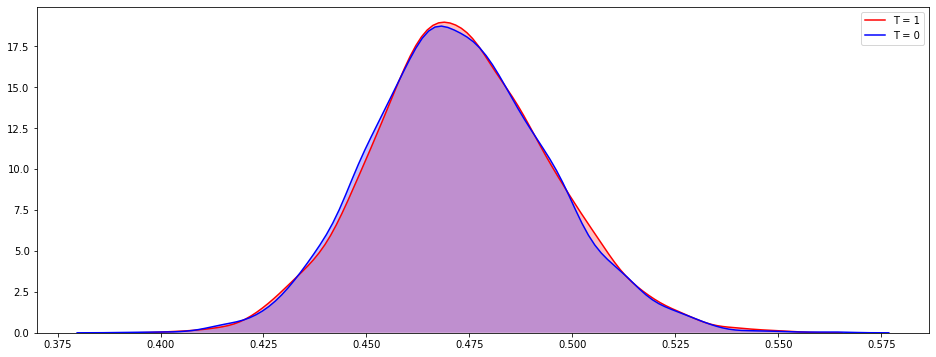

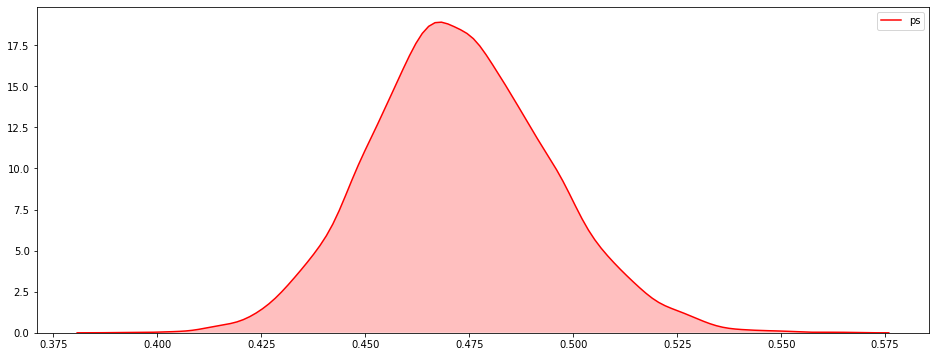

In [11]:
plt.figure(figsize=(16, 6))
sns.kdeplot(last_exp[last_exp['t'] == 1]['ps'], shade=True, color="r",label ='T = 1')
sns.kdeplot(last_exp[last_exp['t'] == 0]['ps'], shade=True, color="b", label ='T = 0')
plt.show()

plt.figure(figsize=(16, 6))
sns.kdeplot(last_exp['ps'], shade=True, color="r")
plt.show()